## Análise de dados do chamado 1746 em grandes eventos

Esse notebook apresenta as respostas para as perguntas do arquivo `perguntas_desafio.md` relacionados a quantidade de chamados 1746 em grande eventos.

O dataset utilizado para a análise é gerado pelo arquivo `02_generate_dataset_chamados_subtype.py`. Nele estão contidos dados referentes a todos os meses dos anos de 2022 e 2023. Cada linha corresponde a um chamado com informações da localização, do tipo `Perturbação do Sossego` (id_subtipo igual a 5071), data de inicio e fim do chamado, além de informações do bairro do chamado. A tabela utilizada para adquirir esses dados é `datario.administracao_servicos_publicos.chamado_1746`. 

# 1. Imports

In [1]:
import pandas as pd
import numpy as np
from datetime import date

# 2. Leitura e validação dos dados

In [2]:
df = pd.read_parquet(
    "../datasets/raw/dataset_chamado_1746_idsub-5071_2022-01-01-2023-12-01.parquet.gzip"
)
print("dataset shape: ", df.shape)
df.head()

dataset shape:  (42408, 32)


,id_chamado,data_inicio,data_fim,id_bairro,id_territorialidade,id_logradouro,numero_logradouro,id_unidade_organizacional,nome_unidade_organizacional,id_unidade_organizacional_mae,...,tempo_prazo,prazo_unidade,prazo_tipo,dentro_prazo,situacao,tipo_situacao,justificativa_status,reclamacoes,data_particao,geometry
0,18353603,2023-02-26 22:00:42,NaT,33,2,66381,359,70,GM-RIO - Guarda Municipal do Rio de Janeiro,GM-RIO - Guarda Municipal do Rio de Janeiro,...,<NA>,D,F,Fora do prazo,Não Encerrado,Andamento,None,0,2023-02-01,POINT(-43.2357612 -22.9239904)
1,18344353,2023-02-24 09:48:16,NaT,52,3,52225,15,70,GM-RIO - Guarda Municipal do Rio de Janeiro,GM-RIO - Guarda Municipal do Rio de Janeiro,...,<NA>,D,F,Fora do prazo,Não Encerrado,Andamento,None,0,2023-02-01,POINT(-43.2629212 -22.8786302)
2,18350630,2023-02-25 15:29:20,NaT,128,4,204339,600,70,GM-RIO - Guarda Municipal do Rio de Janeiro,GM-RIO - Guarda Municipal do Rio de Janeiro,...,<NA>,D,F,Fora do prazo,Não Encerrado,Andamento,None,0,2023-02-01,POINT(-43.3033175 -23.0145087)
3,18347246,2023-02-24 16:19:55,NaT,143,5,137968,25,70,GM-RIO - Guarda Municipal do Rio de Janeiro,GM-RIO - Guarda Municipal do Rio de Janeiro,...,<NA>,D,F,Fora do prazo,Não Encerrado,Andamento,None,0,2023-02-01,POINT(-43.5284028 -22.8737444)
4,18353918,2023-02-27 07:14:08,NaT,143,5,40477,3,70,GM-RIO - Guarda Municipal do Rio de Janeiro,GM-RIO - Guarda Municipal do Rio de Janeiro,...,<NA>,D,F,Fora do prazo,Não Encerrado,Andamento,None,0,2023-02-01,None


A seguir, vamos fazer algumas validações a respeito:
- Tipos dos dados
- Quantidade de valores nulos
- Se existe dados duplicados

In [3]:
## Visualizando dtypes
df.dtypes

id_chamado                                  object
data_inicio                         datetime64[ns]
data_fim                            datetime64[ns]
id_bairro                                   object
id_territorialidade                         object
id_logradouro                               object
numero_logradouro                            Int64
id_unidade_organizacional                   object
nome_unidade_organizacional                 object
id_unidade_organizacional_mae               object
unidade_organizacional_ouvidoria            object
categoria                                   object
id_tipo                                     object
tipo                                        object
id_subtipo                                  object
subtipo                                     object
status                                      object
longitude                                  float64
latitude                                   float64
data_alvo_finalizacao          

Os dados estão com seus tipos corretos e iguais ao visto no BigQuery.

É importante que os id_chamados sejam únicos pois isso garante que cada linha se refira a um único chamado. Para garantir que está tudo correto, vamos verificar se temos ids duplicados

In [4]:
df[df.duplicated(subset=["id_chamado"])]

,id_chamado,data_inicio,data_fim,id_bairro,id_territorialidade,id_logradouro,numero_logradouro,id_unidade_organizacional,nome_unidade_organizacional,id_unidade_organizacional_mae,...,tempo_prazo,prazo_unidade,prazo_tipo,dentro_prazo,situacao,tipo_situacao,justificativa_status,reclamacoes,data_particao,geometry


Como queremos apenas um tipo de subtipo relacionado a pertubação do sossego, precisamos que id_subtipo e subtipo sejam apenas de único tipo.

In [5]:
print("valores únicos id_subtipo: ", pd.unique(df["id_subtipo"]))
print("valores únicos subtipo: ", pd.unique(df["subtipo"]))
df[["id_subtipo", "subtipo"]].nunique()

valores únicos id_subtipo:  ['5071']
valores únicos subtipo:  ['Perturbação do sossego']


id_subtipo    1
subtipo       1
dtype: int64

Também vamos avaliar a quantidade de dados nulos. É importante que não exista id_chamados e id_subtipo nulos e também que cada um seja associado a uma data_inicio pois assim evitamos perdas de registros.

In [6]:
# Verificando valores nulos
(df.isnull().sum() / df.shape[0]) * 100.0

id_chamado                            0.000000
data_inicio                           0.000000
data_fim                              9.915582
id_bairro                             0.247595
id_territorialidade                   0.247595
id_logradouro                         0.247595
numero_logradouro                     4.329372
id_unidade_organizacional             0.000000
nome_unidade_organizacional           0.000000
id_unidade_organizacional_mae         0.000000
unidade_organizacional_ouvidoria      0.000000
categoria                             0.000000
id_tipo                               0.000000
tipo                                  0.000000
id_subtipo                            0.000000
subtipo                               0.000000
status                                0.000000
longitude                            12.165158
latitude                             12.165158
data_alvo_finalizacao                 0.000000
data_alvo_diagnostico               100.000000
data_real_dia

Apenas por cuidado, vamos avaliar se cada particao contém apenas chamados referente ao mês e ano daquela partição.

In [7]:
df_div_monthyear = df[["data_inicio", "data_particao"]].copy()
df_div_monthyear["data_inicio_month"] = df_div_monthyear["data_inicio"].dt.month
df_div_monthyear["data_inicio_year"] = df_div_monthyear["data_inicio"].dt.year
df_div_monthyear.groupby("data_particao")[
    ["data_inicio_month", "data_inicio_year"]
].value_counts()

data_particao  data_inicio_month  data_inicio_year
2022-01-01     1                  2022                1920
2022-02-01     2                  2022                2403
2022-03-01     3                  2022                2285
2022-04-01     4                  2022                2273
2022-05-01     5                  2022                2721
2022-06-01     6                  2022                3110
2022-07-01     7                  2022                3579
2022-08-01     8                  2022                3037
2022-09-01     9                  2022                2562
2022-10-01     10                 2022                2624
2022-11-01     11                 2022                2407
2022-12-01     12                 2022                2192
2023-01-01     1                  2023                2129
2023-02-01     2                  2023                1791
2023-03-01     3                  2023                2270
2023-04-01     4                  2023                1840
2023-

Os dados estão com ótima qualidade! Não existe id_chamado e id_subtipo duplicados e nulos (estão consistentes), os tipos de dados estão corretos e conforme tabela com BigQuery e também cada chamado tem sua data_inicio definida e todos os dados nela correspondem ao ano e mês de sua partição!

# 3. Respondendo perguntas

Com os dados validados, agora vamos responder as perguntas!

## 6. Quantos chamados com o subtipo "Perturbação do sossego" foram abertos desde 01/01/2022 até 31/12/2023 (incluindo extremidades)?


Como nosso dataset contém apenas dados do subtipo pertubação do sossego entre os anos de 2022 e 2023 basta contar o número de linhas

In [8]:
print("quantidade de chamados entre 2022 e 2023: ", df.shape[0])

quantidade de chamados entre 2022 e 2023:  42408


In [9]:
# verificando por data particao
df.groupby("data_particao")["id_chamado"].count()

data_particao
2022-01-01    1920
2022-02-01    2403
2022-03-01    2285
2022-04-01    2273
2022-05-01    2721
2022-06-01    3110
2022-07-01    3579
2022-08-01    3037
2022-09-01    2562
2022-10-01    2624
2022-11-01    2407
2022-12-01    2192
2023-01-01    2129
2023-02-01    1791
2023-03-01    2270
2023-04-01    1840
2023-05-01    1180
2023-06-01    1214
2023-07-01     643
2023-08-01      61
2023-09-01      92
2023-10-01      36
2023-11-01      29
2023-12-01      10
Name: id_chamado, dtype: int64

## 7. Selecione os chamados com esse subtipo que foram abertos durante os eventos contidos na tabela de eventos (Reveillon, Carnaval e Rock in Rio).


As datas dos eventos estão na tabela `datario.turismo_fluxo_visitantes.rede_hoteleira_ocupacao_eventos` ilustrada na imagem abaixo. A partir delas, podemos dividir nosso dataset de acordo com elas e calcular a quantidade de chamados.

![Tabela_ocupac_hotelaria](../images/tabela_datario_hotelaria_ocup_grandes_eventos.png)

In [10]:
# Definindo variáveis de eventos
eventos = {
    "is_RiR2022_w1": {"init_date": date(2022, 9, 2), "final_date": date(2022, 9, 4)},
    "is_RiR2022_w2": {"init_date": date(2022, 9, 8), "final_date": date(2022, 9, 11)},
    "is_reveillon2023": {
        "init_date": date(2022, 12, 30),
        "final_date": date(2023, 1, 1),
    },
    "is_carnaval2023": {
        "init_date": date(2023, 2, 18),
        "final_date": date(2023, 2, 21),
    },
}

In [11]:
# Definindo eventos
def create_col_for_event(
    dataframe: pd.DataFrame,
    name_event: str,
    ref_date_col: str,
    init_date: date,
    final_date: date,
):
    dataframe[name_event] = dataframe[ref_date_col].dt.date.map(
        lambda d: 1.0 if d >= init_date and d <= final_date else 0.0
    )
    return dataframe


for evnt, dates in eventos.items():
    create_col_for_event(
        dataframe=df,
        name_event=evnt,
        ref_date_col="data_inicio",
        init_date=dates["init_date"],
        final_date=dates["final_date"],
    )

In [12]:
# Defininindo a quantidade de eventos
df_chamados_em_eventos = df[
    (df["is_RiR2022_w1"] == 1.0)
    | (df["is_RiR2022_w2"] == 1.0)
    | (df["is_reveillon2023"] == 1.0)
    | (df["is_carnaval2023"] == 1.0)
]
print("Quantidade de chamados em eventos é: ", df_chamados_em_eventos.shape[0])

Quantidade de chamados em eventos é:  1212


## 8. Quantos chamados desse subtipo foram abertos em cada evento?


is_RiR2022_w1       366
is_RiR2022_w2       468
is_reveillon2023    137
is_carnaval2023     241
dtype: int64

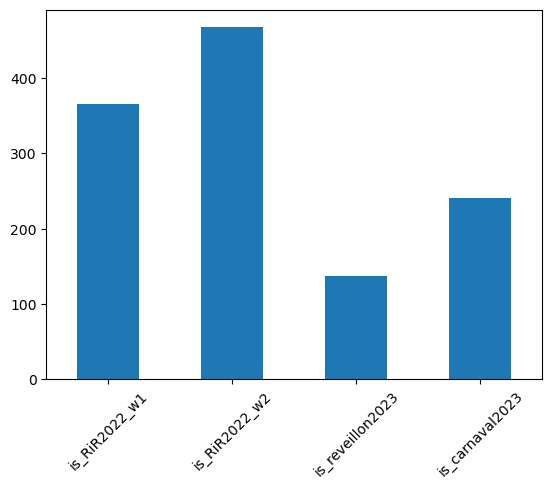

In [13]:
qtd_chamados_eventos = dict()
for col in eventos.keys():
    count_chamados = df_chamados_em_eventos.groupby(col)["id_chamado"].count()
    qtd_chamados_eventos[col] = count_chamados.at[1.0]

s_qtd_chamados_eventos = pd.Series(qtd_chamados_eventos)
s_qtd_chamados_eventos.plot.bar(rot=45)
s_qtd_chamados_eventos

`is_RiR2022_w1` e `is_RiR2022_w2` se referem ao Rock in Rio 2022 e `is_reveillion2023` e `is_carnaval2023` se referem ao Reveillion e Carnaval respectivamente. 

O rock in rio é o evento que mais apresentou chamados do tipo `Perturbação do Sossego` com a segunda semana tendo mais registros (mas em comparação com a semana 1 ela teve 1 dia a mais)

## 9. Qual evento teve a maior média diária de chamados abertos desse subtipo?


is_RiR2022_w1       122.00
is_RiR2022_w2       117.00
is_reveillon2023     45.67
is_carnaval2023      60.25
dtype: float64

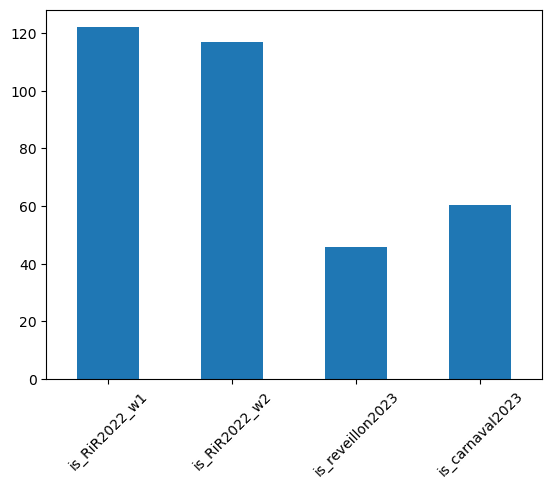

In [14]:
mean_per_day_chamados_eventos = dict()

for col in eventos.keys():
    ct_chamados = (
        df_chamados_em_eventos[df_chamados_em_eventos[col] == 1.0]
        .groupby(df["data_inicio"].dt.date)["id_chamado"]
        .count()
    )
    mean_per_day_chamados_eventos[col] = np.round(
        ct_chamados.sum() / len(ct_chamados), 2
    )

s_mean_per_day_chamados_eventos = pd.Series(mean_per_day_chamados_eventos)
s_mean_per_day_chamados_eventos.plot.bar(rot=45)
s_mean_per_day_chamados_eventos

O Rock in Rio foi o evento com maior médio diária de chamados do tipo perturbação do sossego. A primeira semana com média pouco maior que a segunda, isso porque ela tem 1 dia a menos e então as somas diárias acabam sendo divididas por número menor.

## 10. Compare as médias diárias de chamados abertos desse subtipo durante os eventos específicos (Reveillon, Carnaval e Rock in Rio) e a média diária de chamados abertos desse subtipo considerando todo o período de 01/01/2022 até 31/12/2023.

is_RiR2022_w1              122.000000
is_RiR2022_w2              117.000000
is_reveillon2023            45.670000
is_carnaval2023             60.250000
média_anual_de_chamados     63.201192
dtype: float64

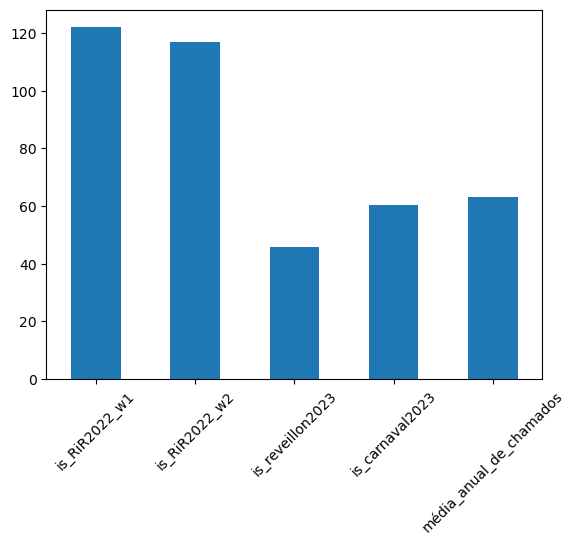

In [15]:
s_compare_eventos = s_mean_per_day_chamados_eventos.copy()
s_total = df.groupby(df["data_inicio"].dt.date)["id_chamado"].count()
mean_total = s_total.sum() / len(s_total)
s_compare_eventos["média_anual_de_chamados"] = mean_total

s_compare_eventos.plot.bar(rot=45)
s_compare_eventos

A média anual de chamados considerando 2022 e 2023 é de 63 chamados de perturbação do sossego ao dia. Isso torna os valores obtidos nas semanas de Rock in Rio bem acima do normal (a semana 1 cerca de 93% maior que a média anual). O carnaval obteve uma média próxima a anual e o reveillon obteve uma média menor que a anual.